In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [41]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import re, nltk, string

from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, homogeneity_score
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

from termcolor import colored
def cprint(text : str, color : str = "yellow") -> None:
  print(colored(text, color))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
df = pd.read_csv("./dataset.csv")

SPECIAL_STOPWORDS = [
    "edu", "line", "subject", "organization", "com", "c", "writes", "year",
    "like", "know", "posting",
    "host", "think", "nntp", "x", "apr", "right", "said",
    "p", "good", "wa", "ha", "u",
]

stop_words = set(stopwords.words('english'))
for sw in STOP_WORDS:
  stop_words.add(sw)
for sw in SPECIAL_STOPWORDS:
  stop_words.add(sw)


stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
model = SentenceTransformer('all-MiniLM-L6-v2')

REPLACE = " "
def preprocess(text):
  text = re.sub(f"[{string.punctuation}]", REPLACE, text)
  text = re.sub(r"\d+", REPLACE, text)
  text = re.sub(r"\s+", REPLACE, text)
  text = text.lower()

  # text = remove_stopwords(text)

  tokens = word_tokenize(text)
  tokens = [word for word in tokens if word not in stop_words]
  # tokens = [stemmer.stem(word) for word in tokens]
  tokens = [lemmatizer.lemmatize(word) for word in tokens]

  return " ".join(tokens)

def preprocess_v2(text):
    text = re.sub(f"[{string.punctuation}]", REPLACE, text)
    text = re.sub(r"\d+", REPLACE, text)
    text = re.sub(r"\s+", REPLACE, text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    tokens = [word for word in tokens
              if word not in stop_words and len(word) > 2]

    return " ".join(tokens)


def preprocess_freq_words(df : pd.DataFrame, N : int) -> None:
    all_texts = " ".join(df["cleaned_text"])
    tokens = word_tokenize(all_texts)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    word_freq = Counter(filtered_tokens)
    most_common_words = word_freq.most_common(N)
    return most_common_words

df["cleaned_text"] = df["document"].apply(preprocess_v2)

# most_freq = preprocess_freq_words(df, 30)
# print(most_freq)

df.head()

,document,cleaned_text
0,From: melabdel@cobra.cs.unm.edu (Mohammed Elab...,melabdel cobra unm mohammed elabdellaoui europ...
1,From: bc744@cleveland.Freenet.Edu (Mark Ira Ka...,cleveland freenet mark ira kaufman israel doe ...
2,From: lundby@rtsg.mot.com (Walter F. Lundby)\n...,lundby rtsg mot walter lundby msg sensitivity ...
3,From: ajs8@kimbark.uchicago.edu (adam jeremy s...,ajs kimbark uchicago adam jeremy schorr graphi...
4,From: npm@netcom.com (Nancy P. Milligan)\nSubj...,npm netcom nancy milligan need advice doctor p...


In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')
feature_vectors = model.encode(df['cleaned_text'].tolist(), show_progress_bar = True)


# model = SentenceTransformer('all-mpnet-base-v2')
# feature_vectors = model.encode(df['cleaned_text'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/122 [00:00<?, ?it/s]

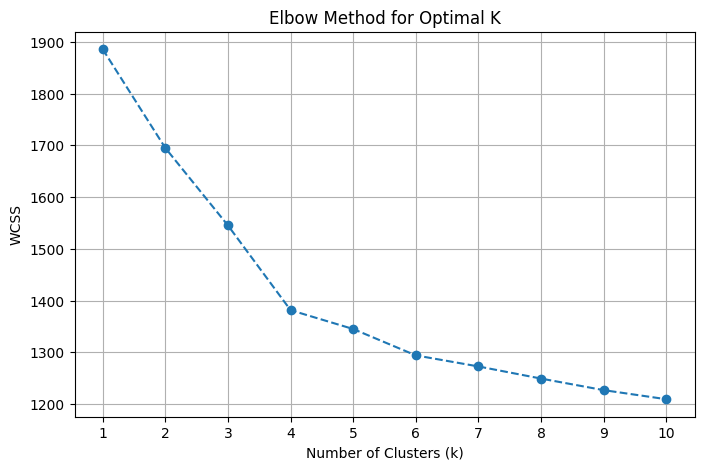

In [27]:
wcss = []
max_k = 10

for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_vectors)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, max_k + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.xticks(range(1, max_k + 1))
plt.grid(True)
plt.show()

In [28]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(feature_vectors)
df['kmeans_cluster'] = kmeans_labels

In [34]:
dbscan = DBSCAN(eps=0.71, min_samples=15)
dbscan_labels = dbscan.fit_predict(feature_vectors)
df['dbscan_cluster'] = dbscan_labels

In [35]:
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(feature_vectors)
df['hierarchical_cluster'] = hierarchical_labels

In [36]:
cprint(f"K-Means Silhouette Score: {silhouette_score(feature_vectors, kmeans_labels):.4f}")
cprint(f"DBSCAN Silhouette Score: {silhouette_score(feature_vectors, dbscan_labels):.4f}")
cprint(f"Hierarchical Silhouette Score: {silhouette_score(feature_vectors, hierarchical_labels):.4f}")

"""
  -- Without any preprocessing.
  5-Means Silhouette Score: 0.0768
  DBSCAN Silhouette Score: -0.0441
  Hierarchical Silhouette Score: 0.0730
"""
#

K-Means Silhouette Score: 0.0646
DBSCAN Silhouette Score: -0.0691
Hierarchical Silhouette Score: 0.0920


'\n  -- Without any preprocessing.\n  5-Means Silhouette Score: 0.0768\n  DBSCAN Silhouette Score: -0.0441\n  Hierarchical Silhouette Score: 0.0730\n'

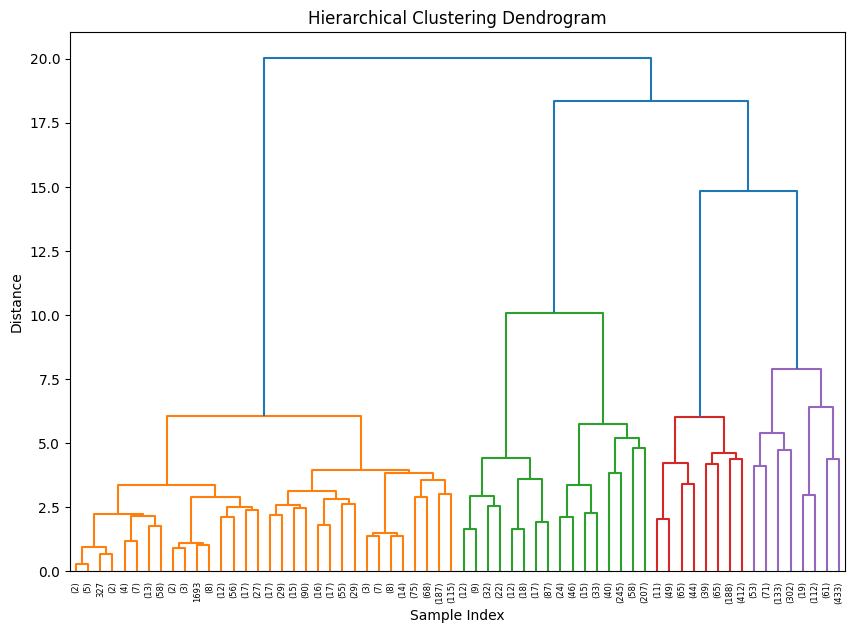

In [33]:
linkage_matrix = linkage(feature_vectors, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

Improved Silhouette Score (GMM): 0.5194


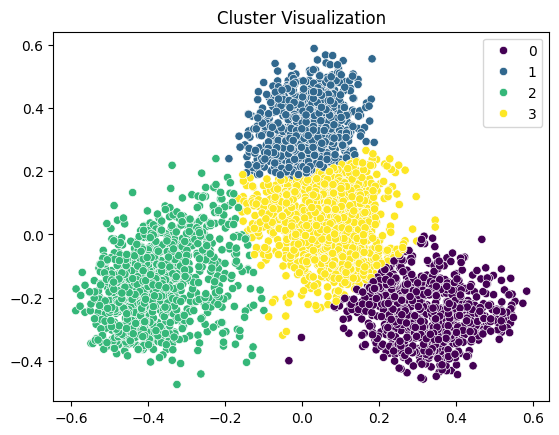

In [38]:
pca_test = PCA(n_components=2)
reduced_vectors = pca_test.fit_transform(feature_vectors)

optimal_k = 4
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
gmm_labels = gmm.fit_predict(reduced_vectors)
df['gmm_cluster'] = gmm_labels

silhouette_avg = silhouette_score(reduced_vectors, gmm_labels)
cprint(f"Improved Silhouette Score (GMM): {silhouette_avg:.4f}", "green")

sns.scatterplot(x=reduced_vectors[:, 0], y=reduced_vectors[:, 1], hue=gmm_labels, palette='viridis')
plt.title('Cluster Visualization')
plt.show()

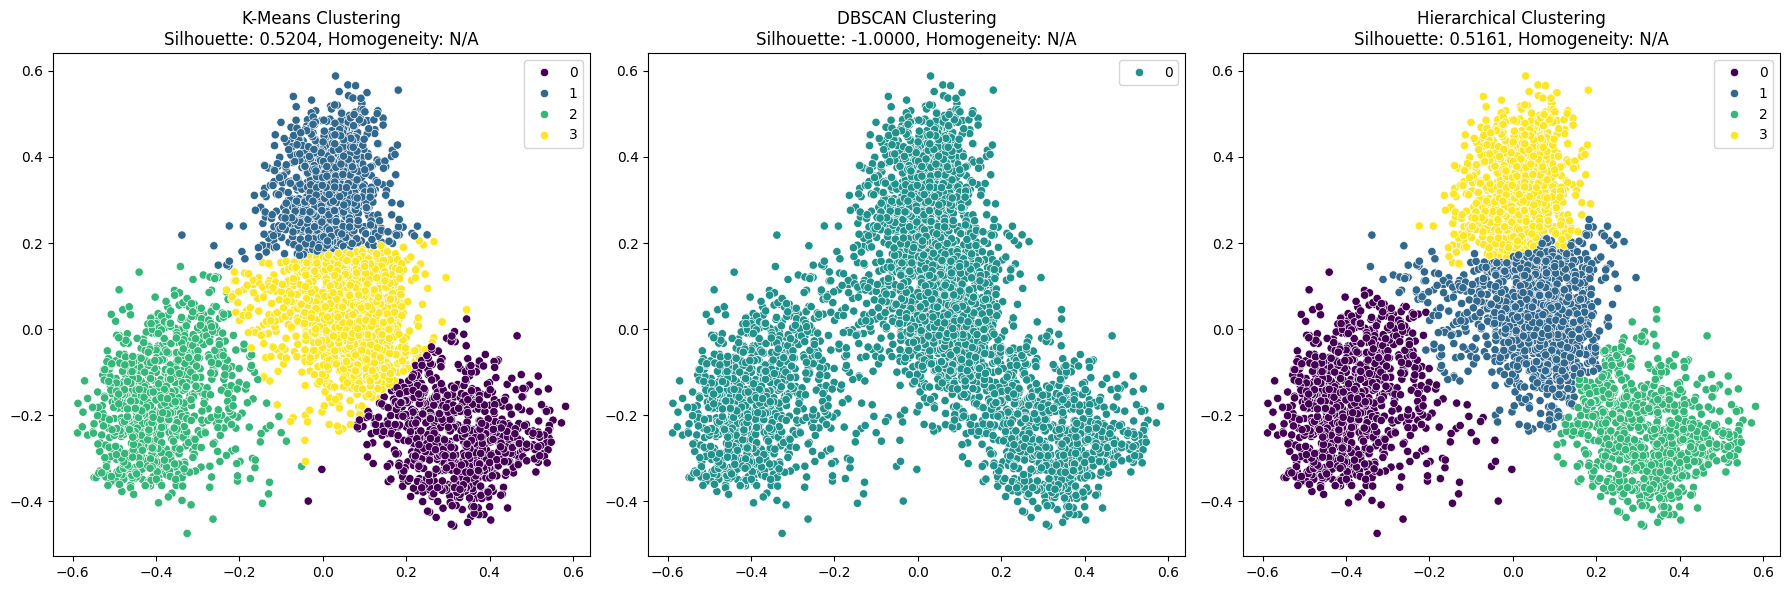

In [46]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(feature_vectors)

optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_features)

dbscan = DBSCAN(eps=0.7, min_samples=15)
dbscan_labels = dbscan.fit_predict(pca_features)

hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(pca_features)

kmeans_silhouette = silhouette_score(pca_features, kmeans_labels)
dbscan_silhouette = silhouette_score(pca_features, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1
hierarchical_silhouette = silhouette_score(pca_features, hierarchical_labels)

if "true_labels" in df.columns:
    true_labels = df["true_labels"]
    kmeans_homogeneity = homogeneity_score(true_labels, kmeans_labels)
    dbscan_homogeneity = homogeneity_score(true_labels, dbscan_labels)
    hierarchical_homogeneity = homogeneity_score(true_labels, hierarchical_labels)
else:
    kmeans_homogeneity = dbscan_homogeneity = hierarchical_homogeneity = None

df["kmeans_cluster_pca"] = kmeans_labels
df["dbscan_cluster_pca"] = dbscan_labels
df["hierarchical_cluster_pca"] = hierarchical_labels

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=kmeans_labels, palette="viridis", legend="full")
plt.title(f"K-Means Clustering\nSilhouette: {kmeans_silhouette:.4f}, Homogeneity: {kmeans_homogeneity:.4f}" if kmeans_homogeneity is not None else f"K-Means Clustering\nSilhouette: {kmeans_silhouette:.4f}, Homogeneity: N/A")

plt.subplot(1, 3, 2)
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=dbscan_labels, palette="viridis", legend="full")
plt.title(f"DBSCAN Clustering\nSilhouette: {dbscan_silhouette:.4f}, Homogeneity: {dbscan_homogeneity:.4f}" if dbscan_homogeneity is not None else f"DBSCAN Clustering\nSilhouette: {dbscan_silhouette:.4f}, Homogeneity: N/A")

plt.subplot(1, 3, 3)
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=hierarchical_labels, palette="viridis", legend="full")
plt.title(f"Hierarchical Clustering\nSilhouette: {hierarchical_silhouette:.4f}, Homogeneity: {hierarchical_homogeneity:.4f}" if hierarchical_homogeneity is not None else f"Hierarchical Clustering\nSilhouette: {hierarchical_silhouette:.4f}, Homogeneity: N/A")

plt.tight_layout()
plt.show()



### 1.
Lemmatization converts a word into its dictionary form whereas Stemming method converts word to its base form by removing prefixes or suffixes. It does not consider linguistic rules.
- Lemmatization is slower but it produces meaningful words whereas Stemming is faster but the resulted words may be meaningless.

### 2.
Preprocessing reduces noise by removing irrelevant data such as stopwords, prefixes, or suffixes. It also improves efficiency in the sense of computation by reducing the size of texts and making it easier to learn patterns for models.

### 3.
We use feature vectors instead of just using the raw text because it reduces dimensionality and computational efficiency, semantic representation of text, compatibality with the clustering algorithms and so on.

### 4.
Supervised learning method is when we try to train a model on labeled data, whereas unsupervised learning workds with unlabeled data. It aims to uncover hidden patterns or groupings within the dataset.

### 5.
We use feature vectors because it encodes the data into a numberical format which is readable for algorithms. It also captures the relevant information and lowers the noise amount in the data.

### 6.
A Sentence Transformer is a type of deep learning model designed to create dense, meaningful embeddings (vector representations) for entire sentences, paragraphs, or documents, rather than individual words. These embeddings capture semantic and contextual meaning, enabling tasks like similarity comparison, clustering, and semantic search.

### 7.
K-Means is a centroid-based clustering algorithm that partitions data into kk clusters by minimizing the sum of squared distances between each point and the centroid of its cluster.

Advantages:

    Simple and Fast: Computationally efficient for large datasets.
    Scalable: Works well with large nn (number of data points).
    Easy to Interpret: Clear and straightforward clustering.

Disadvantages:

    Requires kk: Needs the number of clusters to be predefined.
    Sensitive to Initialization: Poor initial centroids can lead to suboptimal clusters.
    Assumes Spherical Clusters: Struggles with non-globular clusters or varying cluster sizes/densities.
    Sensitive to Outliers: Outliers can skew centroids significantly.

DBSCAN groups data points that are closely packed together (density-based) and marks points in low-density regions as noise.

Advantages:

    No Need for kk: Automatically determines the number of clusters.
    Handles Noise: Can identify and separate noise points.
    Non-Spherical Clusters: Detects clusters of arbitrary shapes.

Disadvantages:

    Parameter Sensitivity: Choosing appropriate εε and minPtsminPts is challenging and dataset-dependent.
    Scalability: Computational cost increases significantly with large datasets.
    Sparse Clusters: May fail if clusters have varying densities.


Hierarchical clustering builds a tree-like structure (dendrogram) by either:
- Agglomerative: Starting with each point as its own cluster and merging iteratively.
- Divisive: Starting with all points in one cluster and splitting iteratively.

Advantages:

    No Need for kk: Dendrogram provides a visual representation to decide the number of clusters.
    Arbitrary Shapes: Works for non-spherical clusters.
    Hierarchical Relationships: Captures nested relationships in data.

Disadvantages:

    Computationally Intensive: Scales poorly with large datasets due to repeated distance calculations.
    Memory Usage: Stores a large distance matrix, limiting scalability.
    Linkage Sensitivity: Results depend on the chosen linkage method.

### 8.
The Elbow Method is a technique used to determine the optimal number of clusters (kk) in K-Means clustering. It involves plotting the Within-Cluster Sum of Squares (WCSS) for different values of kk and identifying the "elbow point" on the graph, where the rate of decrease in WCSS slows down significantly.
- WCSS: Measures the sum of squared distances between each point in a cluster and the cluster's centroid.

$$ WCSS = \Sigma_{i=1}^{k} \Sigma_{x \in C_i} ||x-\mu_i||^2 $$

where $k$ is the number of clusters, $C_i$ is the set of points in cluster $i$, and $\mu_i$ is the centroid of cluster $i$


### 9.
K-Means is generally faster and more scalable. However, it assumes that clusters are of similar size and shape, which may not always hold true. DBSCAN, on the other hand, is better at handling noise and finding arbitrarily shaped clusters, but here it almost consider each text as noise!. Hierarchical clustering provides a flexible, interpretable structure and doesn’t require specifying the number of clusters in advance, but it’s computationally expensive and may not scale well to large datasets.


### 10.
Principal Component Analysis (PCA) is a dimensionality reduction technique used to transform high-dimensional data into a lower-dimensional space while retaining as much variability (information) as possible. PCA achieves this by identifying directions in the data (principal components) where the variance is maximized.

1. Standardize the Data

    PCA assumes the data is centered around the mean and scaled.
    Standardization ensures all features contribute equally:
    $$ Z = \frac{X-\mu}{\sigma} $$
    where $X$ is the original data, $\mu$ is the mean of each feature, and $\sigma$ is the standard deviation of each feature.
  
2. Compute the Covariance Matrix

    Measures the linear relationship between features:

    $$ Covariance Matrix C = \frac{1}{n-1}(Z^T Z) $$
    where $C$ is a square matrix with size $d \times d$, $d$ being the number of features.

3. Find Eigenvalues and Eigenvectors

    Eigenvalues represent the amount of variance explained by each principal component.
    Eigenvectors represent the directions (principal components) in the feature space.

4. Sort Principal Components

    Rank eigenvalues in descending order to prioritize components with the most variance.
    Corresponding eigenvectors are sorted similarly.

5. Project Data

    Project the original data onto the top kk principal components:
    $$ Z_{reduced} = Z.W_k $$
    where $W_k$ is the matrix of the top k eigenvectors and $Z_{reduced}$ is the transformed data in $k$-dimensional space.

### 11.
The silhouette score measures the quality of clustering by evaluating how well each point fits within its assigned cluster compared to other clusters. It ranges from $−1$ to $1$, where higher values indicate better-defined clusters.
$$ S(i) = \frac{b(i) - a(i}{max(a(i), b(i)} $$
where $a(i)$ is the average distance between ii and all other points in the same cluster (intra-cluster distance) and $b(i)$ is the average distance between ii and all points in the nearest neighboring cluster (inter-cluster distance).


Homogeneity is derived from entropy:
$$ h = 1 - \frac{H(C|K)}{H(C)} $$
where $H(C)$ is the entropy of the true class distribution, and $H(C|K)$ is the conditional entropy of the classes given the clusters.